# Multiclass image classification using Transfer learning

Image classification is one of the supervised machine learning problems which aims to categorize the images of a dataset into their respective categories or labels. Classification of images of various dog breeds is a classic image classification problem. So, we have to classify more than one class that's why the name multi-class classification, and in this article, we will be doing the same by making use of a pre-trained model InceptionResNetV2, and customizing it.

Transfer learning: Transfer learning is a popular deep learning method that follows the approach of using the knowledge that was learned in some task and applying it to solve the problem of the related target task. So, instead of creating a neural network from scratch we "transfer" the learned features which are basically the "weights" of the network. To implement the concept of transfer learning, we make use of "pre-trained models".

Necessities for transfer learning: Low-level features from model A (task A) should be helpful for learning model B (task B).

 Pre-trained model: Pre-trained models are the deep learning models which are trained on very large datasets, developed, and are made available by other developers who want to contribute to this machine learning community to solve similar types of problems. It contains the biases and weights of the neural network representing the features of the dataset it was trained on. The features learned are always transferrable. For example, a model trained on a large dataset of flower images will contain learned features such as corners, edges, shape, color, etc.

InceptionResNetV2: InceptionResNetV2 is a convolutional neural network that is 164 layers deep, trained on millions of images from the ImageNet database, and can classify images into more than 1000 categories such as flowers, animals, etc. The input size of the images is 299-by-299.

Dataset description:

The dataset used comprises of 120 breeds of dogs in total.

Each image has a file name which is its unique id.

Train dataset ( train.zip ): contains 10,222 images which are to be used for training our model

Test dataset (test.zip ): contains 10,357 images which we have to classify into the respective categories or labels.

labels.csv: contains breed names corresponding to the image id.

sample_submission.csv: contains correct form of sample submission to be made

### We first import all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

d:\mini projects\projects\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Loading datasets and image folders

In [4]:
# datasets
labels = pd.read_csv("labels.csv")
sample = pd.read_csv('sample_submission.csv')

# folders paths
train_path = "train"
test_path = "test"

### Displaying the first five records of labels dataset to see its attributes.

In [5]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Adding '.jpg' extension to each id 

This is done in order to fetch the images from the folder since the image name and id's are the same so adding .jpg extension will help us in retrieving images easily.

In [6]:
def to_jpg(id):
    return id+".jpg"


labels['id'] = labels['id'].apply(to_jpg)
sample['id'] = sample['id'].apply(to_jpg)

### Augmenting data:

It's a pre-processing technique in which we augment the existing dataset with transformed versions of the existing images. We can perform scaling, rotations, increasing brightness, and other affine transformations. This is a useful technique as it helps the model to generalize the unseen data well.

ImageDataGenerator class is used for this purpose which provides a real-time augmentation of data.a 

Description of few of its parameters that are used below:

rescale: rescales values by the given factor

horizontal flip: randomly flip inputs horizontally.

validation_split: this is the fraction of images reserved for validation (between 0 and 1).

In [7]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )

train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)


validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


Let's see what a single batch of data looks like.

In [8]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 331, 331, 3)

### Plotting images from the train dataset

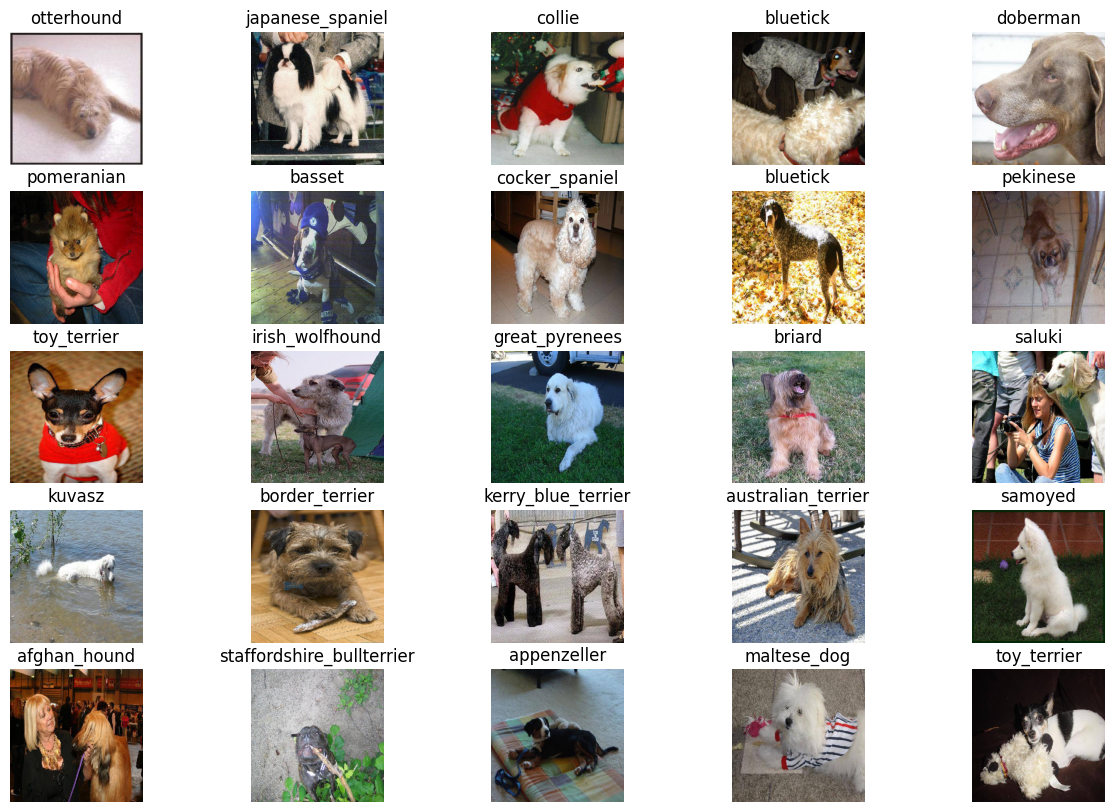

In [9]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

### Building our Model

This is the main step where the neural convolution model is built.

In [10]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )

base_model.trainable=False

# Build the model and pass an input with a defined shape 
# so the model can infer the shapes of all the layers
input_tensor = tf.keras.Input(shape=(331,331,3))
output_tensor = base_model(input_tensor)

# Now build the rest of the model
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='softmax')
    ])


### BatchNormalization :

It is a normalization technique which is done along mini-batches instead of the full data set.
It is used to speed up training and use higher learning rates.
It maintains the mean output close to 0 and the output standard deviation close to 1.

### GlobalAveragePooling2D :

It takes a tensor of size (input width) x (input height) x (input channels) and computes the average value of all values across the entire (input width) x (input height) matrix for each of the (input channels).
The dimensionality of the images is reduced by reducing the number of pixels in the output from the previous neural network layer.
By using this we get a 1-dimensional tensor of size (input channels) as our output.
2D Global average pooling operation. Here 'Depth' = 'Filters'

### Dense Layers: 

These layers are regular fully connected neural network layers connected after the convolutional layers.

### Drop out layer: 

This is also used whose function is to randomly drop some neurons from the input unit so as to prevent overfitting. The value of 0.5 indicates that 0.5 fractions of neurons have to be dropped.

### Compile the model:

Before training our model we first need to configure it and that is done by model.compile() which defines the loss function, optimizers, and metrics for prediction.

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for 
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

### Displaying a summary report of the model

By displaying the summary we can check our model to confirm that everything is as expected.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 9, 9, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,309,528 (210.99 MB)

 Trainable params: 969,720 (3.70 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

### Defining callbacks to preserve the best results:

Callback: It is an object that can perform actions at various stages of training (for example, at the start or end of an epoch, before or after a single batch, etc).

In [15]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

Training the model: It means that we are finding a set of values for weights and biases that have a low loss on average across all the records.

In [16]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])


Epoch 1/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 1509s 6s/step - accuracy: 0.7536 - loss: 1.1198 - val_accuracy: 0.8839 - val_loss: 0.5345
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7500 - loss: 1.1246 - val_accuracy: 0.8829 - val_loss: 0.5417
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 1473s 6s/step - accuracy: 0.8586 - loss: 0.5868 - val_accuracy: 0.8998 - val_loss: 0.3889
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.9375 - loss: 0.2329 - val_accuracy: 0.8978 - val_loss: 0.3983
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 1454s 6s/step - accuracy: 0.8682 - loss: 0.5246 - val_accuracy: 0.8894 - val_loss: 0.4765
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.8125 - loss: 1.0319 - val_accuracy: 0.8914 - val_loss: 0.4659
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 1450s 6s/step - accuracy: 0.8758 - loss: 0.4788 - val_accuracy: 0.8958 - val_loss: 0.4423
Epoch 8/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.8750 - loss: 0.4844 - val_

### Save the model

We can save the model for further use.

In [17]:
model.save("Model.h5")

### Visualizing the model's performance

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9006874561309814\nValidation Accuracy: 0.9067460298538208')

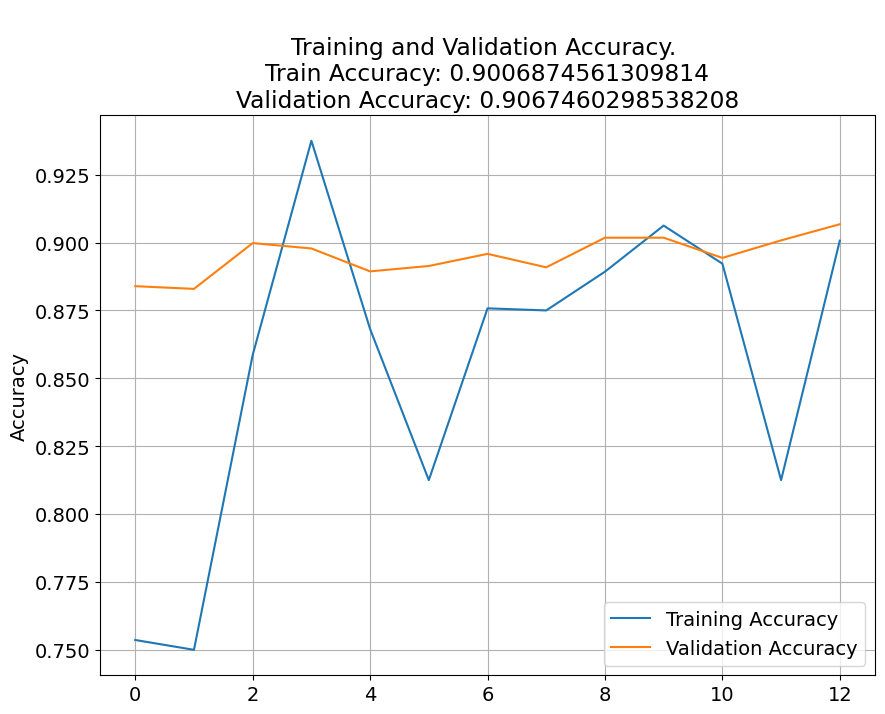

In [18]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

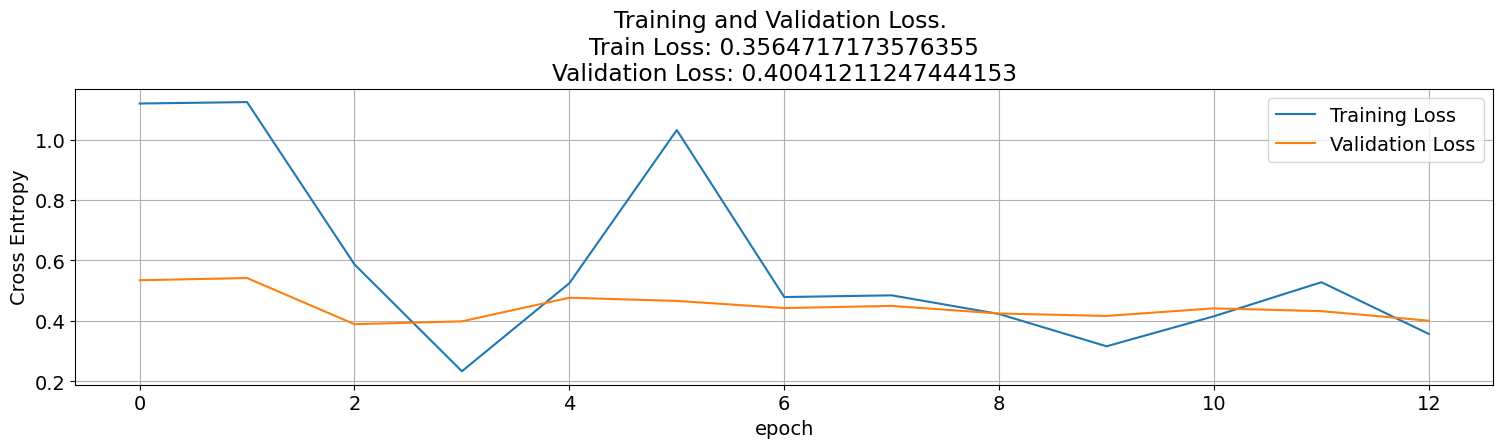

In [19]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

A line graph of training vs validation accuracy and loss was also plotted. The graph indicates that the accuracies of validation and training were almost consistent with each other and above 90%. The loss of the CNN model is a negative lagging graph which indicates that the model is behaving as expected with a reducing loss after each epoch.

### Evaluating the accuracy of the model

In [20]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 

print("Loss: ",accuracy_score[0])

64/64 ━━━━━━━━━━━━━━━━━━━━ 301s 5s/step - accuracy: 0.8977 - loss: 0.3869
[0.3869219124317169, 0.8977494835853577]
Accuracy: 89.7749%
Loss:  0.3869219124317169


### Viewing the Test Image

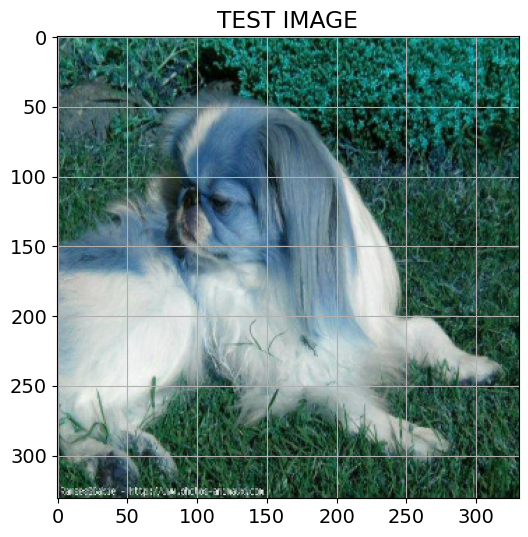

In [21]:
test_img_path = test_path+"/000621fb3cbb32d8935728e48679680e.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255

plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

### Making predictions on the test data

In [22]:
predictions = []

for image in sample.id:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': sample.id, 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)

# Submission file output
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 